# Capstone 4 - Building a Recommendation System Using Clustering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

user_artist = pd.read_table('lastfm/user_artists.dat')
user_taggedartists = pd.read_table('lastfm/user_taggedartists.dat')
user_taggedartists_timestamps = pd.read_table('lastfm/user_taggedartists-timestamps.dat')
user_friends = pd.read_table('lastfm/user_friends.dat')
tags = pd.read_table('lastfm/tags.dat', encoding='latin-1')
artists = pd.read_table('lastfm/artists.dat')


In [2]:
user_artist.isna().sum()

userID      0
artistID    0
weight      0
dtype: int64

In [3]:
user_taggedartists.isna().sum()

userID      0
artistID    0
tagID       0
day         0
month       0
year        0
dtype: int64

In [4]:
user_taggedartists_timestamps.isna().sum()

userID       0
artistID     0
tagID        0
timestamp    0
dtype: int64

In [5]:
user_friends.isna().sum()

userID      0
friendID    0
dtype: int64

In [6]:
tags.isna().sum()

tagID tagValue    0
dtype: int64

In [7]:
#tags.columns = ['tagID', 'tagValue']
tags = tags.rename(columns={'tagID tagValue': 'tagValue'})
tags

,tagValue
1,metal
2,alternative metal
3,goth rock
4,black metal
5,death metal
...,...
12644,suomi
12645,symbiosis
12646,sverige
12647,eire


In [8]:
artists.isna().sum()

id              0
name            0
url             0
pictureURL    444
dtype: int64

In [27]:
artists.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [34]:
artists.iloc[0,:]

id                                                          1
name                                             MALICE MIZER
url                     http://www.last.fm/music/MALICE+MIZER
pictureURL    http://userserve-ak.last.fm/serve/252/10808.jpg
Name: 0, dtype: object

In [53]:
artist_id_to_name = {artists.iloc[x,0]: artists.iloc[x,1] for x in range(artists.shape[0])}
artist_name_to_id = {artists.iloc[x,1].lower(): artists.iloc[x,0] for x in range(artists.shape[0])}

In [9]:
top_artists = user_artist.groupby(['artistID']).count()
top_artists = top_artists.merge(artists, left_on='artistID', right_on='id')
top_artists = top_artists[['name', 'userID']].sort_values(by='userID', ascending=False)
top_artists = top_artists.rename(columns={'name': 'Artist', 'userID': 'Likes'})
top_twenty_artists = top_artists[:20]


In [10]:
top_twenty_artists

,Artist,Likes
83,Lady Gaga,611
283,Britney Spears,522
282,Rihanna,484
221,The Beatles,480
294,Katy Perry,473
61,Madonna,429
327,Avril Lavigne,417
286,Christina Aguilera,407
184,Muse,400
492,Paramore,399


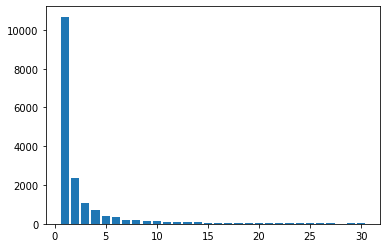

In [11]:
like_freq_u30 = top_artists.Likes.value_counts()[top_artists.Likes.value_counts().index <= 30]

plt.bar(like_freq_u30.index,
        like_freq_u30.values)
plt.show()

In [46]:
tag_freq = pd.merge(user_taggedartists.tagID.value_counts(), tags, left_index=True, right_index=True)
tag_freq.rename(columns={'tagID': 'Frequency', 'tagValue': 'Tag'}, inplace=True)
tag_freq = tag_freq[['Tag', 'Frequency']]
tag_freq[:10]

,Tag,Frequency
73,rock,7503
24,pop,5418
79,alternative,5251
18,electronic,4672
81,indie,4458
130,female vocalists,4228
25,80s,2791
39,dance,2739
78,alternative rock,2631
192,classic rock,2287


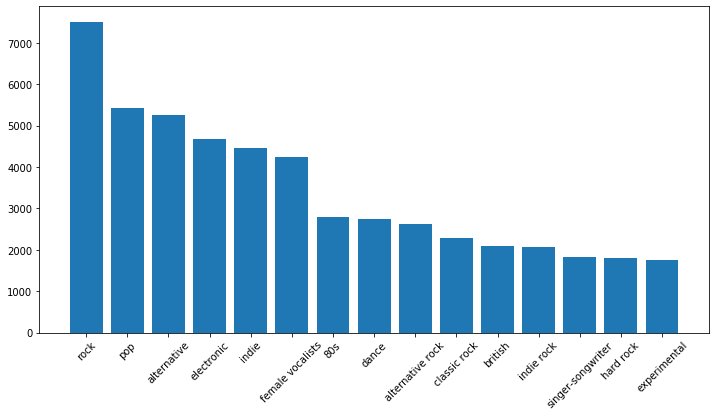

In [52]:
plt.figure(figsize=(12,6))
plt.bar(tag_freq[:15]['Tag'], tag_freq[:15]['Frequency'])
plt.xticks(rotation=45)
plt.show()

In [13]:
content_vector = []

for i in range(max(artists.id)):
    artist = user_taggedartists[user_taggedartists.artistID == i]
    vc = artist.tagID.value_counts()
    
    newvec = [0]*(max(user_taggedartists.tagID)+1)
    newvec[0] = i
    
    for j in vc.index:
        newvec[j] = vc[j]/max(vc)

    content_vector.append(newvec)

content_vector = pd.DataFrame(content_vector)
content_vector.rename(columns = {0: 'artistID'}, inplace=True)
content_vector

,artistID,1,2,3,4,5,6,7,8,9,...,12638,12639,12640,12641,12642,12643,12644,12645,12646,12647
0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.000000,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.333333,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18740,18740,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18741,18741,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18742,18742,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18743,18743,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
pd.concat([content_vector[73], content_vector[24], content_vector[79], content_vector[18], content_vector[81]], axis=1).corr()

,73,24,79,18,81
73,1.000000,0.119020,0.384189,-0.039279,0.196445
24,0.119020,1.000000,0.075703,0.046584,0.072592
79,0.384189,0.075703,1.000000,0.054913,0.368231
18,-0.039279,0.046584,0.054913,1.000000,0.079013
81,0.196445,0.072592,0.368231,0.079013,1.000000


In [16]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=20)
clusters = km.fit(content_vector.iloc[:,1:])

In [134]:
predict = pd.Series(clusters.predict(content_vector.iloc[:,1:]))

<BarContainer object of 20 artists>

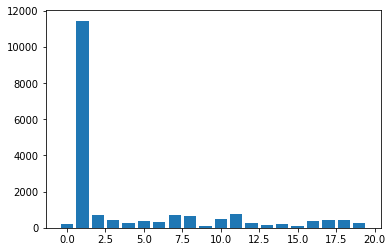

In [135]:
plt.bar(predict.value_counts().index, predict.value_counts())

In [20]:
ids = content_vector.artistID[predict==0]
[artists['name'][artists.id==x] for x in ids]

[501    Saosin
 Name: name, dtype: object, 745    Maximum the Hormone
 Name: name, dtype: object, 759    Enter Shikari
 Name: name, dtype: object, 807    A Day to Remember
 Name: name, dtype: object, 818    Ignite
 Name: name, dtype: object, 820    It Prevails
 Name: name, dtype: object, 1171    Escape The Fate
 Name: name, dtype: object, 1172    Silverstein
 Name: name, dtype: object, 1176    Alesana
 Name: name, dtype: object, 1183    Four Year Strong
 Name: name, dtype: object, 1186    Alexisonfire
 Name: name, dtype: object, 1202    Lärm
 Name: name, dtype: object, 1530    Chainsaw Disaster
 Name: name, dtype: object, 1536    Raimundos
 Name: name, dtype: object, 1537    boysetsfire
 Name: name, dtype: object, 1538    Hatebreed
 Name: name, dtype: object, 1539    wecamewithbrokenteeth
 Name: name, dtype: object, 1854    Hollywood Undead
 Name: name, dtype: object, 1859    A Skylit Drive
 Name: name, dtype: object, 2170    ВFI
 Name: name, dtype: object, 2172    Stick to Your Guns
 

In [21]:
def get_artists(cluster, n=20):
    ids = content_vector.artistID[predict==cluster]
    artist_list = [artists['name'][artists.id==x] for x in ids]
    for i in range(n):
        print(artist_list[i])
        
get_artists(0)

501    Saosin
Name: name, dtype: object
745    Maximum the Hormone
Name: name, dtype: object
759    Enter Shikari
Name: name, dtype: object
807    A Day to Remember
Name: name, dtype: object
818    Ignite
Name: name, dtype: object
820    It Prevails
Name: name, dtype: object
1171    Escape The Fate
Name: name, dtype: object
1172    Silverstein
Name: name, dtype: object
1176    Alesana
Name: name, dtype: object
1183    Four Year Strong
Name: name, dtype: object
1186    Alexisonfire
Name: name, dtype: object
1202    Lärm
Name: name, dtype: object
1530    Chainsaw Disaster
Name: name, dtype: object
1536    Raimundos
Name: name, dtype: object
1537    boysetsfire
Name: name, dtype: object
1538    Hatebreed
Name: name, dtype: object
1539    wecamewithbrokenteeth
Name: name, dtype: object
1854    Hollywood Undead
Name: name, dtype: object
1859    A Skylit Drive
Name: name, dtype: object
2170    ВFI
Name: name, dtype: object


In [136]:
get_artists(1)

Series([], Name: name, dtype: object)
1    Diary of Dreams
Name: name, dtype: object
2    Carpathian Forest
Name: name, dtype: object
4    Bella Morte
Name: name, dtype: object
5    Moonspell
Name: name, dtype: object
8    Combichrist
Name: name, dtype: object
9    Grendel
Name: name, dtype: object
10    Agonoize
Name: name, dtype: object
11    Behemoth
Name: name, dtype: object
12    Hocico
Name: name, dtype: object
Series([], Name: name, dtype: object)
13    Dimmu Borgir
Name: name, dtype: object
14    London After Midnight
Name: name, dtype: object
15    Psyclon Nine
Name: name, dtype: object
18    Limbonic Art
Name: name, dtype: object
19    Artista sconosciuto
Name: name, dtype: object
20    xotox
Name: name, dtype: object
21    The Kovenant
Name: name, dtype: object
22    Feindflug
Name: name, dtype: object
24    Tamtrum
Name: name, dtype: object


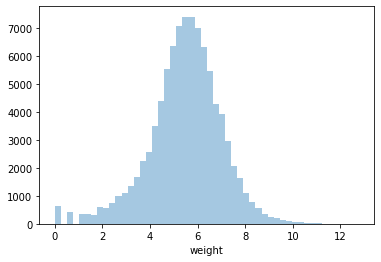

In [58]:
import seaborn as sns

sns.distplot(np.log(user_artist.weight), kde=False)
plt.show()

In [61]:
user_artist['weight'] = np.log(user_artist['weight'])

In [90]:
user_likes_vector = []

for a in range(len(user_artist.artistID.unique())):
    artist_id = user_artist.artistID.unique()[a]
    artist_df = user_artist[user_artist.artistID == artist_id]
    newvec = [0]*2101
    newvec[0] = user_artist.artistID.unique()[a]
    user_likes_vector.append(newvec)
    for row in range(artist_df.shape[0]):
        newvec[artist_df.iloc[row,0]] = artist_df.iloc[row,2]

pd.DataFrame(user_likes_vector)



,0,1,2,3,4,5,6,7,8,9,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,51,0,9.538420,0.0,5.429346,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.000000
1,52,0,9.366489,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.000000
2,53,0,9.337061,0.0,6.530878,5.198497,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.000000
3,54,0,9.239899,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.000000
4,55,0,9.103089,0.0,0.000000,0.000000,0.0,8.055475,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17627,18726,0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,5.820083
17628,18727,0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,5.693732
17629,18728,0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,5.638355
17630,18729,0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,5.634790


In [64]:
print(max(user_artist.userID))
print(max(user_artist.artistID))
print(user_artist.shape)

2100
18745
(92834, 3)


In [92]:
user_likes_vector = pd.DataFrame(user_likes_vector)

In [125]:
from sklearn.cluster import MiniBatchKMeans

minik = MiniBatchKMeans(n_clusters=10, init='random')
clusters_sim_users = minik.fit_predict(user_likes_vector.iloc[:,1:])

<BarContainer object of 10 artists>

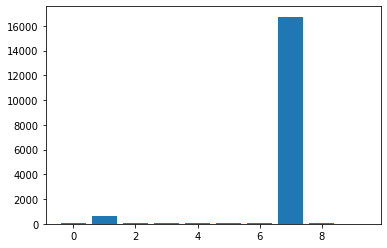

In [126]:
plt.bar(pd.Series(clusters_sim_users).value_counts().index, pd.Series(clusters_sim_users).value_counts())

In [129]:
pd.Series(clusters_sim_users).value_counts()

7    16733
1      612
2       49
4       48
6       46
0       36
8       32
5       30
3       29
9       17
dtype: int64

In [113]:
#clusters_sim_users[8000:8030]

cluster_1 = [artist_id_to_name[x] for x in user_likes_vector.iloc[:,0][clusters_sim_users==1]]

cluster_1[:20]

['Chuck Berry',
 'Buddy Holly',
 'The Rockats',
 "The 5.6.7.8's",
 'Batmobile',
 'The Brian Setzer Orchestra',
 'Stray Cats',
 'Los Straitjackets',
 'Prince Buster',
 'The Meteors',
 'Charlie Feathers',
 'Restless',
 'ブラック・キャッツ',
 'Billy Briggs',
 'Jets',
 'Tex Williams',
 'Polecats',
 'Hank Thompson',
 'Frenzy',
 'Curtis Gordon']

In [114]:
cluster_2 = [artist_id_to_name[x] for x in user_likes_vector.iloc[:,0][clusters_sim_users==2]]

cluster_2[:20]

['Mercedes Sosa']

In [115]:
cluster_3 = [artist_id_to_name[x] for x in user_likes_vector.iloc[:,0][clusters_sim_users==3]]

cluster_3[:20]

['Fergie', 'Glee Cast', 'Moulin Rouge']

In [116]:
cluster_4 = [artist_id_to_name[x] for x in user_likes_vector.iloc[:,0][clusters_sim_users==4]]

cluster_4[:20]

['Armin van Buuren', 'Tiësto', 'Ferry Corsten']

In [ ]:
from sklearn import metrics 
from scipy.spatial.distance import cdist 

X = content_vector.iloc[:,1:]

distortions = []
inertias = []

k_range = range(1,50)

for k in k_range:
    model = KMeans(n_clusters = k).fit(X)
    model.fit(X)
    distortions.append(sum(np.min(cdist(X, model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    inertias.append(model.inertia_)

plt.subplot(1,2,1)
plt.plot([x for x in range(1,50)], distortions)

plt.subplot(1,2,2)
plt.plot([x for x in range(1,50)], inertias)

plt.show()

In [141]:
X = content_vector.iloc[:,1:]

distortions = []
inertias = []

k_range = range(1,50)

for k in k_range:
    model = KMeans(n_clusters = k).fit(X)
    model.predict(X)
    distortions.append(sum(np.min(cdist(X, model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    inertias.append(model.inertia_)

plt.subplot(1,2,1)
plt.plot([x for x in range(1,50)], distortions)

plt.subplot(1,2,2)
plt.plot([x for x in range(1,50)], inertias)

plt.show()

KeyboardInterrupt: 

In [ ]:
X = content_vector.iloc[:,1:]

distortions = []
inertias = []

k_range = range(1,50)

for k in k_range:
    model = KMeans(n_clusters = k).fit(X)
    distortions.append(sum(np.min(cdist(X, model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    inertias.append(model.inertia_)

plt.subplot(1,2,1)
plt.plot([x for x in range(1,50)], distortions)

plt.subplot(1,2,2)
plt.plot([x for x in range(1,50)], inertias)

plt.show()

In [ ]:
X = user_likes_vector.iloc[:,1:]

distortions = []
inertias = []

k_range = range(1,50)

for k in k_range:
    model = KMeans(n_clusters = k).fit(X)
    model.fit(X)
    distortions.append(sum(np.min(cdist(X, model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    inertias.append(model.inertia_)

plt.subplot(1,2,1)
plt.plot([x for x in range(1,50)], distortions)

plt.subplot(1,2,2)
plt.plot([x for x in range(1,50)], inertias)

plt.show()